# Предсказание оттока клиентов

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

In [1]:
!pip install --upgrade pip
!pip install --upgrade Pillow
!pip install --upgrade scikit-learn==1.5.0
!pip install --upgrade matplotlib==3.7.3
!pip install ydata_profiling
!pip install catboost

In [2]:
import pandas as pd

import ydata_profiling
from ydata_profiling import ProfileReport

import numpy as np

import lightgbm
from lightgbm import LGBMClassifier

import catboost
from catboost import CatBoostClassifier

import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor

import os

import matplotlib
import matplotlib.pyplot as plt

In [3]:
RANDOM_STATE = 50824

Библиотеки подключены, нужные инструменты импортированы.

Переходим к загрузке, исследованию и предобработке данных.

## Загрузка, анализ и предобработка данных

Загрузим данные и посмотрим краткую информацию об их содержании.

In [4]:
pth1 = r'c:\users\natasha\desktop\портфолио ГИТ\Выпускной проект\contract_new.csv'

if os.path.exists(pth1):
    contract = pd.read_csv(pth1)
    contract.info()
else:
    print('Ошибка загрузки файла')    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [5]:
pth2 = r'c:\users\natasha\desktop\портфолио ГИТ\Выпускной проект\personal_new.csv'

if os.path.exists(pth2):
    personal = pd.read_csv(pth2)
    personal.info()
else:
    print('Ошибка загрузки файла')    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [6]:
pth3 = r'c:\users\natasha\desktop\портфолио ГИТ\Выпускной проект\internet_new.csv'

if os.path.exists(pth3):
    internet = pd.read_csv(pth3)
    internet.info()    
else:
    print('Ошибка загрузки файла', pth3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [7]:
pth4 = r'c:\users\natasha\desktop\портфолио ГИТ\Выпускной проект\phone_new.csv'

if os.path.exists(pth4):
    phone = pd.read_csv(pth4)
    phone.info()
else:
    print('Ошибка загрузки файла', pth4)  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В каждом из датафреймов есть столбец "customerID". 

Объединим их в один датафрейм по значениям указанного столбца, сохраняя все значения.

In [8]:
data = contract.merge(personal, on='customerID', how='outer')

In [9]:
data = data.merge(internet, on='customerID', how='outer')

In [10]:
data = data.merge(phone, on='customerID', how='outer')
data = data.set_index('customerID')

Теперь рассмотрим анализ данных, содержащихся в сводной таблице.

In [11]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

После объединения в столбцах 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines' образовались пропуски. Заполним их.

In [12]:
internet_list = ['InternetService', 
                 'OnlineSecurity', 
                 'OnlineBackup', 
                 'DeviceProtection', 
                 'TechSupport', 
                 'StreamingTV', 
                 'StreamingMovies'
                ]

for n in internet_list:
    data[n] = data[n].fillna(value='No')

data['MultipleLines'] = data['MultipleLines'].fillna(value='Nophone')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   7043 non-null   object 
 12  OnlineSecurity    7043 non-null   object 
 13  OnlineBackup      7043 non-null   object 
 14  DeviceProtection  7043 non-null   object 
 15  TechSupport       7043 non-null   object 
 16  StreamingTV       7043 non-null 

Тип данных в столбце 'TotalCharges' не соответствует их содержанию. Столбец содержит числа, но количество уникальных знаков 12, значит один из них "лишний".

In [14]:
set(data['TotalCharges'].apply(list).sum())

{' ', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}

"Лишний" - пробел. Уберем пробел из данных и удалим строки, в которых образовались пустые значения.

In [15]:
data['TotalCharges'] = data['TotalCharges'].str.strip()

In [16]:
data = data.loc[data['TotalCharges'] != '']

In [17]:
data['TotalCharges'] = data['TotalCharges'].astype('float64')

C:\Users\Natasha\AppData\Local\Temp\ipykernel_8224\308374642.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalCharges'] = data['TotalCharges'].astype('float64')


Создадим столбец с целевым признаком, где 0 - договор не расторгнут, 1 - договор расторгнут.

In [18]:
data['Target'] = data['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

C:\Users\Natasha\AppData\Local\Temp\ipykernel_8224\3747882322.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Target'] = data['EndDate'].apply(lambda x: 0 if x == 'No' else 1)


<Axes: xlabel='Target', ylabel='count'>

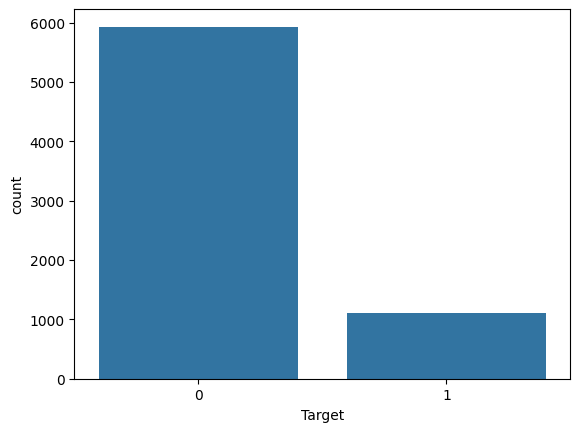

In [19]:
%matplotlib inline
sns.countplot(x='Target', data=data)

In [20]:
data_target = data.pivot_table(index='Target', values='gender', aggfunc='count')
data_target

,gender
Target,
0,5931
1,1101


Видим дисбаланс классов. Это необходимо учесть при подборе модели.

Создадим дополнительный признак 'ContractDuration', который показывает длительность контракта в днях, а признаки 'EndDate' и 'BeginDate' удалим во избежание утечки целевого признака.

In [21]:
data['EndDate'] = data['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)

C:\Users\Natasha\AppData\Local\Temp\ipykernel_8224\422472669.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EndDate'] = data['EndDate'].apply(lambda x: '2020-02-01' if x == 'No' else x)


In [22]:
data['EndDate'] = pd.to_datetime(data['EndDate'])
data['BeginDate'] = pd.to_datetime(data['BeginDate'])
data['ContractDuration'] = (data['EndDate'] - data['BeginDate']).dt.days
data = data.drop(['BeginDate', 'EndDate'], axis=1)

C:\Users\Natasha\AppData\Local\Temp\ipykernel_8224\4072383865.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EndDate'] = pd.to_datetime(data['EndDate'])
C:\Users\Natasha\AppData\Local\Temp\ipykernel_8224\4072383865.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['BeginDate'] = pd.to_datetime(data['BeginDate'])
C:\Users\Natasha\AppData\Local\Temp\ipykernel_8224\4072383865.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

Удалим дублирующие строки.

In [23]:
data = data.drop_duplicates()

In [24]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Target,ContractDuration
customerID,,,,,,,,,,,,,,,,,,,
0002-ORFBO,One year,Yes,Mailed check,65.6,631.73,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No,0,276
0003-MKNFE,Month-to-month,No,Mailed check,59.9,539.10,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes,0,276
0004-TLHLJ,Month-to-month,Yes,Electronic check,73.9,406.45,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No,0,153
0011-IGKFF,Month-to-month,Yes,Electronic check,98.0,1372.00,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No,0,427
0013-EXCHZ,Month-to-month,Yes,Mailed check,83.9,444.67,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No,0,153


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7028 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7028 non-null   object 
 1   PaperlessBilling  7028 non-null   object 
 2   PaymentMethod     7028 non-null   object 
 3   MonthlyCharges    7028 non-null   float64
 4   TotalCharges      7028 non-null   float64
 5   gender            7028 non-null   object 
 6   SeniorCitizen     7028 non-null   int64  
 7   Partner           7028 non-null   object 
 8   Dependents        7028 non-null   object 
 9   InternetService   7028 non-null   object 
 10  OnlineSecurity    7028 non-null   object 
 11  OnlineBackup      7028 non-null   object 
 12  DeviceProtection  7028 non-null   object 
 13  TechSupport       7028 non-null   object 
 14  StreamingTV       7028 non-null   object 
 15  StreamingMovies   7028 non-null   object 
 16  MultipleLines     7028 non-null 

Итак, первая часть проекта выполнена:
- данные загружены и объединены в один датафрейм
- сделан обзор данных, выявлены проблемные места
- мультиколлинеарность среди признаков не обнаружена
- столбец с ID клиентов сделан индексами
- пропуски в данных, возникшие после объединения, заполнены
- типы данных приведены в соответствие с их содержанием
- создан столбец с новым признаком - длительность действия контракта (ContractDuration)
- столбцы, которые могут привести к утечке целевого признака, (BeginDate и EndDate) удалены
- добавлен столбец с целевым признаком (Target), при подборе модели необходимо учесть дисбаланс классов в этом столбце
- удалены дубликаты, всего при предобработке данных удалено 15 строк, что составляет менее 1 процента данных
- итоговая таблица имеет 19 столбцов и 7028 строк.

## Обучение и выбор модели

Выделим целевой признак, разделим данные на тренировочную и тестовую выборки.

In [26]:
X = data.drop(['Target'], axis=1)
y = data['Target']
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.25,
        random_state=RANDOM_STATE
    )

Выделим среди столбцов категориальные и числовые для их корректной обработки.

In [27]:
cat_columns = ['Type', 'PaymentMethod', 'Partner', 'PaperlessBilling', 'Dependents', 'SeniorCitizen', 
               'InternetService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
               'StreamingTV', 'StreamingMovies', 'gender'
              ]

num_columns = ['MonthlyCharges', 'TotalCharges', 'ContractDuration']

Создадим пайплайн для обработки данных.

In [28]:
data_preprocessor = ColumnTransformer(
    [
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=1005001000), cat_columns),
        ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Для оценки работы моделей будем использовать метрику ROC-AUC

In [29]:
scorer = 'roc_auc'

Перейдем к обучению моделей и подбору гиперпараметров.

Будем использовать модели, основанные на деревьях решений, на работу котрых не влияет дисбаланс классов: LGBMClassifier, DecisionTreeClassifier, CatBoostClassifier.

Для подбора гиперпараметров и оценки работы моделей на кросс-валидации будем использовать GridSearchCV.

In [30]:
pipe_final_1 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMClassifier(random_state=RANDOM_STATE))
])

In [31]:
param_model_1 = {
    'models__max_depth': (3, 5),
    'models__learning_rate': (0.01, 0.1, 0.3, 0.5),
    'models__n_estimators': (30, 50, 100)
}


model_1 = GridSearchCV(
    pipe_final_1, 
    param_model_1, 
    cv=5, 
    scoring=scorer, 
    n_jobs=-1
)
model_1.fit(X_train, y_train)

print('Модель и её параметры:\n\n', model_1.best_estimator_), 
print(f'Метрика: {model_1.best_score_}')

[LightGBM] [Info] Number of positive: 823, number of negative: 4448
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 5271, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.156137 -> initscore=-1.687254
[LightGBM] [Info] Start training from score -1.687254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [32]:
pipe_final_2 = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [33]:
param_model_2 = {
    'models__max_depth': range(2, 10),
    'models__max_features': range(2, 10),
    'models__min_samples_leaf': range(1, 5)
}

In [34]:
model_2 = GridSearchCV(
    pipe_final_2, 
    param_model_2, 
    cv=5, 
    scoring=scorer, 
    n_jobs=-1
)
model_2.fit(X_train, y_train)

print('Модель и её параметры:\n\n', model_2.best_estimator_), 
print(f'Метрика: {model_2.best_score_}')

Модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=1005001000),
                                                  ['Type', 'PaymentMethod',
                                                   'Partner',
                                                   'PaperlessBilling',
                                                   'Dependents',
                                                   'SeniorCitizen',
                                                   'InternetService',
                                                   'MultipleLines',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                

In [35]:
pd.DataFrame.iteritems = pd.DataFrame.items
pipe_final_3 = Pipeline([
    ('models', CatBoostClassifier(loss_function="MultiClass", iterations=50, random_state=RANDOM_STATE))
])

param_model_3 = {
    'models__depth': (3, 4, 5),
    'models__learning_rate': (0.01, 0.1, 0.3, 0.5)    
}

model_3 = GridSearchCV(
    pipe_final_3, 
    param_model_3, 
    cv=5, 
    scoring=scorer, 
    n_jobs=-1
)
model_3.fit(X_train, y_train, models__cat_features=cat_columns)

print('Модель и её параметры:\n\n', model_3.best_estimator_)
print(f'Метрика: {model_3.best_score_}')

C:\Users\Natasha\.conda\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
1 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Natasha\.conda\envs\practicum\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Natasha\.conda\envs\practicum\lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\Natasha\.conda\envs\practicum\lib\site-packages\sklearn\pipeline.py", line 476, in fit
    self._final_estimator

0:	learn: 0.4975074	total: 152ms	remaining: 7.42s
1:	learn: 0.4239464	total: 162ms	remaining: 3.89s
2:	learn: 0.3917785	total: 173ms	remaining: 2.71s
3:	learn: 0.3752525	total: 183ms	remaining: 2.11s
4:	learn: 0.3611901	total: 193ms	remaining: 1.74s
5:	learn: 0.3537244	total: 204ms	remaining: 1.49s
6:	learn: 0.3402641	total: 214ms	remaining: 1.31s
7:	learn: 0.3330533	total: 224ms	remaining: 1.18s
8:	learn: 0.3308588	total: 235ms	remaining: 1.07s
9:	learn: 0.3287707	total: 245ms	remaining: 980ms
10:	learn: 0.3261250	total: 255ms	remaining: 905ms
11:	learn: 0.3244744	total: 265ms	remaining: 840ms
12:	learn: 0.3238130	total: 275ms	remaining: 783ms
13:	learn: 0.3224591	total: 283ms	remaining: 728ms
14:	learn: 0.3205462	total: 292ms	remaining: 682ms
15:	learn: 0.3184951	total: 302ms	remaining: 642ms
16:	learn: 0.3178970	total: 312ms	remaining: 606ms
17:	learn: 0.3156002	total: 325ms	remaining: 577ms
18:	learn: 0.3151730	total: 336ms	remaining: 548ms
19:	learn: 0.3145472	total: 347ms	remaini

Лучшая модель - LGBMClassifier(learning_rate=0.5, max_depth=3)

Значение метрики на тренировочной выборке - 0.8831902246601571, что соответствует техническому заданию.

## Анализ работы лучшей модели

Оценим работу лучшей модели на тестовой выборке.

In [36]:
y_pred_proba = model_1.best_estimator_.predict_proba(X_test)
print(f'Метрика лучшей модели на тестовой выборке: {roc_auc_score(y_test, y_pred_proba[:,1])}')

Метрика лучшей модели на тестовой выборке: 0.9095368735437614


Проанализируем важность признаков

In [37]:
importances = model_1.best_estimator_._final_estimator.feature_importances_
data_preprocessor.fit(X_train)
feature_names = data_preprocessor.get_feature_names_out()

In [38]:
f_i = pd.DataFrame(columns=['col_names', 'features_importances'])
f_i['col_names'] = pd.Series(feature_names)
f_i['features_importances'] = pd.Series(importances)
f_i = f_i.sort_values(by=['features_importances'], ascending=False)
f_i

,col_names,features_importances
17,num__ContractDuration,290
15,num__MonthlyCharges,118
16,num__TotalCharges,97
1,cat__PaymentMethod,24
0,cat__Type,23
2,cat__Partner,18
7,cat__MultipleLines,11
10,cat__DeviceProtection,11
4,cat__Dependents,10
11,cat__TechSupport,9


In [39]:
data.pivot_table(index='Target', values=['MonthlyCharges', 'TotalCharges', 'ContractDuration'], aggfunc=['mean', 'median'])

mean                                       median  \
       ContractDuration MonthlyCharges TotalCharges ContractDuration   
Target                                                                 
0            895.193015      62.815151  2071.398999            702.0   
1            924.863760      75.546004  2371.377275            915.0   

                                    
       MonthlyCharges TotalCharges  
Target                              
0               69.25      1194.28  
1               84.20      2139.03

In [40]:
data[['MonthlyCharges', 'TotalCharges', 'ContractDuration', 'Target']].query('Target == 1').describe()

,MonthlyCharges,TotalCharges,ContractDuration,Target
count,1101.000000,1101.000000,1101.000000,1101.0
mean,75.546004,2371.377275,924.863760,1.0
std,29.116213,1581.862275,458.771309,0.0
min,18.400000,77.840000,28.000000,1.0
25%,56.150000,1048.050000,577.000000,1.0
50%,84.200000,2139.030000,915.000000,1.0
75%,99.500000,3404.910000,1249.000000,1.0
max,118.750000,7649.760000,2129.000000,1.0


In [41]:
data[['MonthlyCharges', 'TotalCharges', 'ContractDuration', 'Target']].query('Target == 0').describe()

,MonthlyCharges,TotalCharges,ContractDuration,Target
count,5927.000000,5927.000000,5927.000000,5927.0
mean,62.815151,2071.398999,895.193015,0.0
std,29.830236,2193.086743,716.258826,0.0
min,18.250000,19.050000,31.000000,0.0
25%,30.200000,377.000000,245.000000,0.0
50%,69.250000,1194.280000,702.000000,0.0
75%,87.325000,3176.000000,1523.000000,0.0
max,118.600000,9221.380000,2314.000000,0.0


На предсказания модели больше всего влияют длительность действия контракта и суммы оплаты. Причем у пользователей, расторгнувших контракт, средние значения этих показателей выше.

Рассмотрим матрицу ошибок.

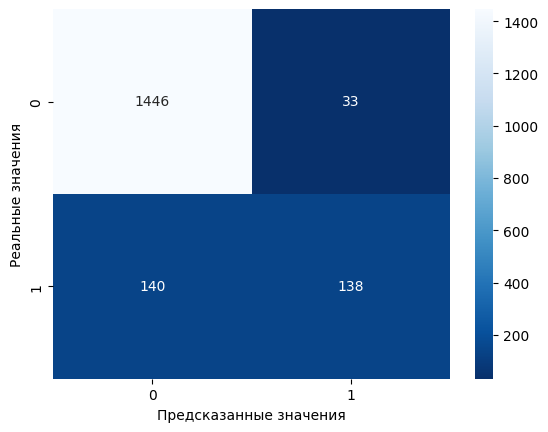

In [42]:
y_pred = model_1.best_estimator_.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Реальные значения')
plt.xlabel('Предсказанные значения');

In [43]:
print('recall: ', recall_score(y_test, y_pred))
print('precision: ', precision_score(y_test, y_pred))
print('accuracy: ', accuracy_score(y_test, y_pred))

recall:  0.49640287769784175
precision:  0.8070175438596491
accuracy:  0.9015367103016505


Модель имеет довольно низкое значение метрики recall, почти плоловина ушедших клиентов предсказаны, как оставшиеся. По условиям задачи такое значение не может являться удовлетворительным, необходимо максимально выявить клиентов, которые собираются расторгнуть контракт. Попробуем подобрать подходящий порог классификации, который не повлияет сильно на общую точность предсказаний (accuracy), также важно, чтобы количество ложноположительных предсказаний не сильно увеличилось, так как это может повлечь неоправданное снижение прибыльности бизнеса из-за большого количества скидок. Для этого рассчитаем значения метрик для разных порогов классификации и построим их график.

In [44]:
pred = pd.DataFrame(y_pred_proba, columns = ['0', '1'])
pred.head(1)

,0,1
0,0.827995,0.172005


In [45]:
thresholds = [round(i,2) for i in np.linspace(0.01, 0.99, num = 50, endpoint=False)]

In [46]:
columns = []

for i in thresholds:
    columns.append('y_pred_'+str(i))
    pred['y_pred_'+str(i)] = pred['1'].apply(lambda y_proba: 1 if (y_proba >= i) else 0)

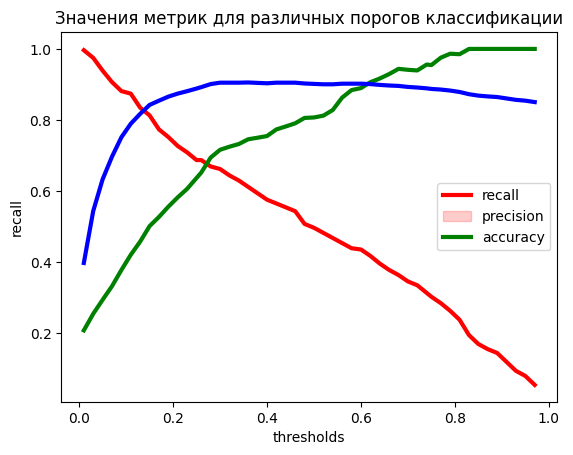

In [47]:
select = pd.DataFrame()
recall = []
precision = []
accuracy = []

for i in columns:
    recall.append(recall_score(y_test, pred[i]))
    precision.append(precision_score(y_test, pred[i]))
    accuracy.append(accuracy_score(y_test, pred[i]))

select['thresholds'] = thresholds
select['recall'] = recall
select['precision'] = precision
select['accuracy'] = accuracy
    
sns.lineplot(x = 'thresholds', y = 'recall', data=select, color='r', lw=3)
sns.lineplot(x = 'thresholds', y = 'precision', data=select, color='g', lw=3)
sns.lineplot(x = 'thresholds', y = 'accuracy', data=select, color='b', lw=3)
plt.legend(labels=['recall','precision', 'accuracy'], facecolor='white')
plt.title('Значения метрик для различных порогов классификации');

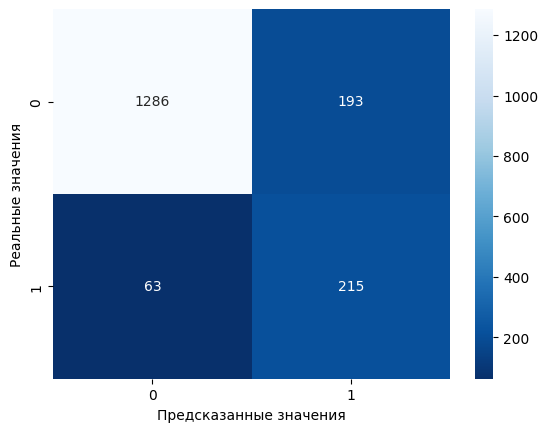

In [48]:
cm_0_17 = confusion_matrix(y_test, pred['y_pred_0.17'])
sns.heatmap(cm_0_17, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Реальные значения')
plt.xlabel('Предсказанные значения');

In [49]:
print('recall: ', recall_score(y_test, pred['y_pred_0.17']))
print('precision: ', precision_score(y_test, pred['y_pred_0.17']))
print('accuracy: ', accuracy_score(y_test, pred['y_pred_0.17']))

recall:  0.7733812949640287
precision:  0.5269607843137255
accuracy:  0.8542970973249858


Оптимальное значение порога классификации - 0,17: 21% ложноотрицательных предсказаний, общая точность предсказаний снизилась на 7%.

## Общий вывод

В ходе выполнения проекта мной была подобрана лучшая модель и ее гиперпараметры для предсказания оттока клиентов.

План работы был следующий:
- загрузка, анализ и предобработка данных, подготовка для использования при обучении моделей,
- обучение моделей, выбор лучшей,
- анализ работы лучшей модели.

Все пункты плана были выполнены:
1) данные загружены, далее для того, чтобы подготовить данные для использования при обучении моделей, я применила следующие способы:

- объединила данные в одну таблицу, провела анализ получившейся таблицы,
- заполнила пропуски в данных, возникшие после объединения,
- привела форматы данных в соответствие с их содержанием,
- добавила дополнительный признак - длительность контракта, 
- удалила признаки, которые могут привести к утечке целевого признака - это дата начала действия контракта и дата окончания действия контракта.

2) для подбора лучшей модели и ее гиперпараметров были использованы пайплайны и инструменты подбора гиперпараметров для каждой модели отдельно, чтобы выбрать лучшую модель самостоятельно. Для исследования я выбрала модели, основанные на деревьях решений, так как в данных присутствует дисбаланс классов: DecisionTreeClassifier, LGBMClassifier, CatBoostClassifier.

Лучшая модель - LGBMClassifier(learning_rate=0.5, max_depth=3), значение метрики на тренировочной выборке - 0.8831902246601571, на тестовой выборке - 0.9095368735437614.

3) при обучении модели использовались признаки:            
 1   PaperlessBilling            
 2   PaymentMethod                 
 3   MonthlyCharges          
 4   TotalCharges           
 5   gender                
 6   SeniorCitizen             
 7   Partner           
 8   Dependents           
 9   InternetService            
 10  OnlineSecurity           
 11  OnlineBackup            
 12  DeviceProtection            
 13  TechSupport            
 14  StreamingTV            
 15  StreamingMovies            
 16  MultipleLines            
 17  Type             
 18  ContractDuration           

Для более точного предсказания оттока клиентов необходимо снизить порог классификации, я предлагаю значение 0,17, но для точного выбора порога необходимо произвести анализ экономической составляющей.

По итогам анализа значимости признаков выявились наиболее значимые для предсказания целевого признака - это длительность действия контракта и суммы оплаты. Причем у пользователей, расторгнувших контракт, средние значения этих показателей выше. Поэтому можно предположить, что предложение скидок и специальных условий клиентам, которые в соответствии с прогнозом модели планируют отказаться от услуг связи, может положительно сказаться на их лояльности и уменьшить отток клиентов.